In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import os

In [2]:
df = pd.read_parquet("../data/train_image_similarity.snappy.parquet", engine="pyarrow")

## Векторизация текста

Этап 1: TF-IDF для заголовков

In [3]:
all_titles = pd.concat([df['base_title'], df['cand_title']]).reset_index(drop=True)

tfidf = TfidfVectorizer(
    max_features=50_000,
    ngram_range=(1, 2),
    tokenizer=lambda x: x.split(),
    lowercase=False
)
title_vectors = tfidf.fit_transform(all_titles)

base_title_vec = title_vectors[:len(df)]
cand_title_vec = title_vectors[len(df):]

c:\Users\Джамиля\Documents\project file\for cv\AvitoMLCup\venv\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Этап 2: Word2Vec для описаний

In [4]:
all_descriptions = pd.concat([df['base_description'], df['cand_description']])
sentences = [text.split() for text in all_descriptions]

w2v_model = Word2Vec(
    sentences,
    vector_size=100,    # Размер вектора
    window=5,          # Размер контекста
    min_count=3,       # Игнорировать редкие слова
    workers=4,         # Параллельные процессы
    epochs=10          # Количество эпох обучения
)

def text_to_vec(text):
    words = text.split()  # Разбиваем уже очищенную строку
    vectors = [w2v_model.wv[word] for word in words if word in w2v_model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(w2v_model.vector_size)

base_desc_vec = np.array([text_to_vec(text) for text in df['base_description']])
cand_desc_vec = np.array([text_to_vec(text) for text in df['cand_description']])

Этап 3: Расчёт схожести заголовков

In [5]:
from sklearn.metrics.pairwise import paired_cosine_distances

# Convert to CSR format if not already
base_title_vec = base_title_vec.tocsr()
cand_title_vec = cand_title_vec.tocsr()

# Compute cosine similarity directly between corresponding pairs
df['title_similarity'] = 1 - paired_cosine_distances(base_title_vec, cand_title_vec)

Этап 4: Расчёт схожести описаний 

In [6]:
from scipy.sparse import csr_matrix

# Convert to sparse if not already
base_sparse = csr_matrix(base_desc_vec)
cand_sparse = csr_matrix(cand_desc_vec)

df['description_similarity'] = 1 - paired_cosine_distances(base_sparse, cand_sparse)

In [7]:
df.to_parquet(os.path.join("..", "data", "train_final_dataset.snappy.parquet"))

Анализ

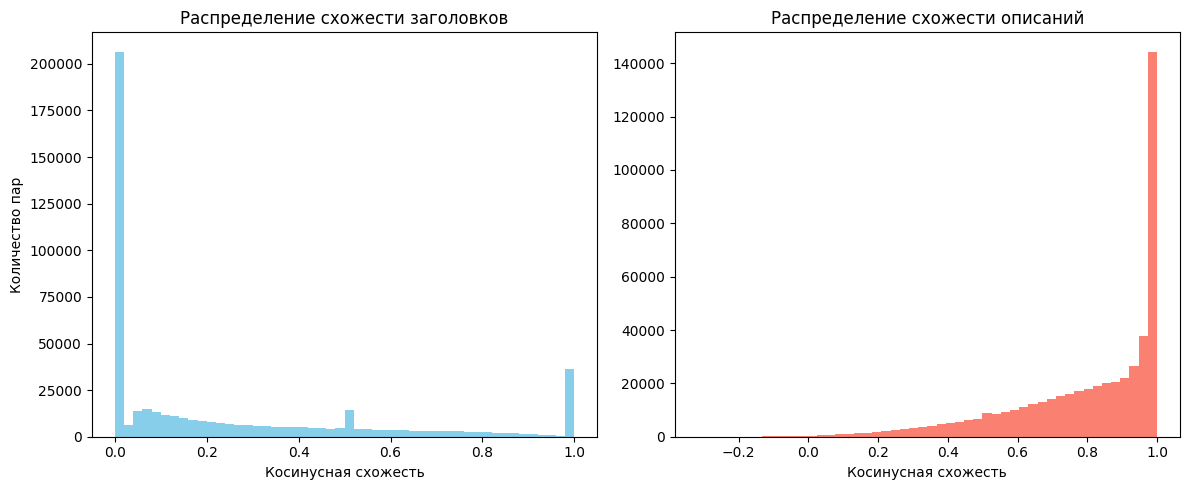

In [8]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(df['title_similarity'], bins=50, color='skyblue')
plt.title('Распределение схожести заголовков')
plt.xlabel('Косинусная схожесть')
plt.ylabel('Количество пар')

plt.subplot(1, 2, 2)
plt.hist(df['description_similarity'], bins=50, color='salmon')
plt.title('Распределение схожести описаний')
plt.xlabel('Косинусная схожесть')

plt.tight_layout()
plt.show()